                                                        TRANSFER LEARNING - RESNET-18                                                                                                                 

data preprocessing - organizing the images as training and validation folders

In [ ]:
import os
import pandas as pd
import shutil #Used to copy image files from one place to another
from sklearn.model_selection import train_test_split
from tqdm import tqdm  #For progress bars while copying files


labels_df = pd.read_csv('dog-breed-identification/labels.csv')
print("Total images:", len(labels_df))
print("Number of unique breeds:", labels_df['breed'].nunique())

os.makedirs('dataset/train', exist_ok=True)
os.makedirs('dataset/valid', exist_ok=True)


train_df, valid_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['breed'],
    random_state=42
)


def organize_images(df, split_type):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_id = row['id']
        breed = row['breed']
        
        src_path = f'dog-breed-identification/train/{img_id}.jpg'
        dst_dir = f'dataset/{split_type}/{breed}'
        dst_path = f'{dst_dir}/{img_id}.jpg'
        
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, dst_path)


print("Organizing training images")
organize_images(train_df, 'train')

print("Organizing validation images")
organize_images(valid_df, 'valid')


Total images: 10222
Number of unique breeds: 120
Organizing training images...


100%|██████████| 8177/8177 [01:31<00:00, 89.80it/s] 


Organizing validation images...


100%|██████████| 2045/2045 [00:21<00:00, 95.15it/s]


In [ ]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


 Check Class Distribution

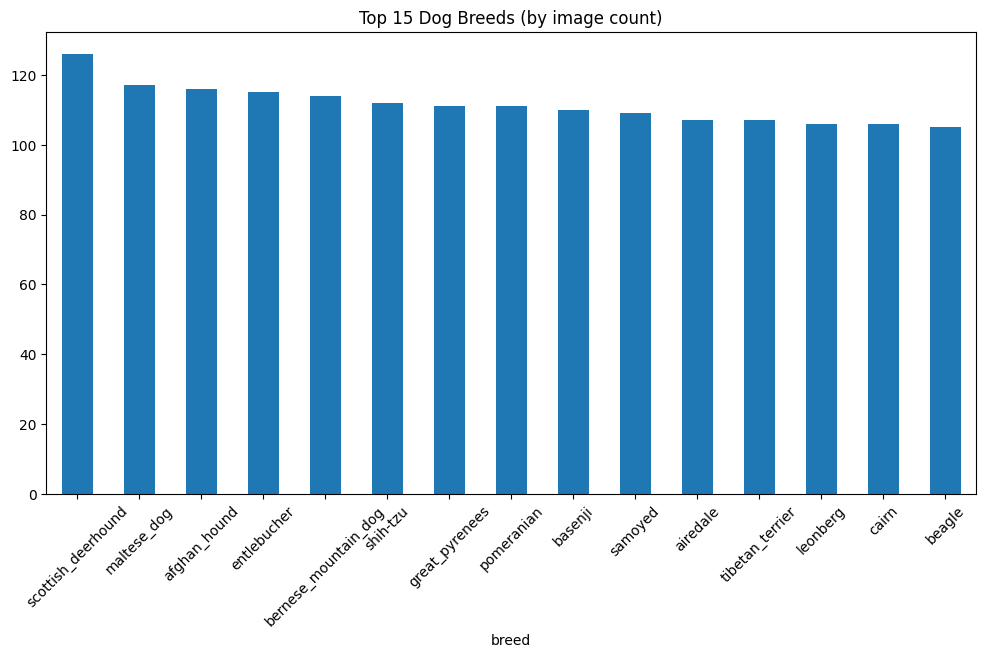

In [8]:
plt.figure(figsize=(12, 6))
labels_df['breed'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Dog Breeds (by image count)')
plt.xticks(rotation=45)
plt.show()


Data Augmentation and Dataloaders - This step will help the model generalize better and prevent overfitting. The Augmentation only apply for training images only

<h4>Required Libraries<h4>

In [ ]:
import torch
from torchvision import datasets, transforms #Used to resize, normalize, augment images before training.
from torch.utils.data import DataLoader 


data augmentation and normalization

In [ ]:
image_size = 224

mean = [0.485, 0.456, 0.406] #normalization constants  for pretrained Models
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

valid_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

Create Dataset and Dataloaders

In [ ]:
train_dir = 'dataset/train'
valid_dir = 'dataset/valid'


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


num_classes = len(train_dataset.classes)
print("Number of classes: " , num_classes)

Number of classes:  120


 visualize augmented images

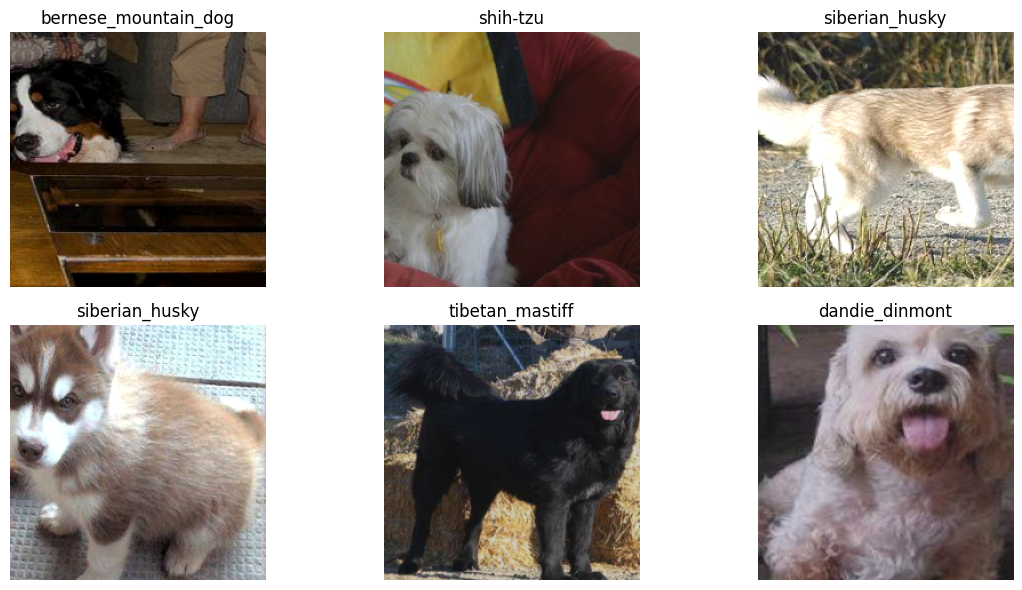

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(image_tensor, label):
    image = image_tensor.numpy().transpose((1, 2, 0)) 
    image = std * image + mean  # Unnormalize tha values to view real image colors
    image = np.clip(image, 0, 1)   
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

# Get one batch of images and labels
images, labels = next(iter(train_loader))


plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    show_image(images[i], train_dataset.classes[labels[i]])
plt.tight_layout()
plt.show()


Build the Transfer Learning Model (ResNet-18)

In [4]:
#Import the required Libraries
import torch 
import torch.nn as nn 
import torchvision.models as models


Load Pre-trained ResNet


In [5]:
model = models.resnet18(pretrained=True)

c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sachi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import pandas as pd

csv_path = "dog-breed-identification/labels.csv"

labels_df = pd.read_csv(csv_path)

class_names = sorted(labels_df['breed'].unique().tolist())

print(f"Number of classes: {len(class_names)}")
print(f"Example class names: {class_names[:5]}")



Number of classes: 120
Example class names: ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier']


In [ ]:
#Freeze All Layers

for param in model.parameters():  #We freeze all layers to retain the learned features like edges, corners, textures 
    param.requires_grad = False
    
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))


 Define Loss & Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.fc.parameters(),lr=0.001)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


 Train the Model 

In [ ]:
from tqdm import tqdm
import torch

num_epochs = 30
patience = 5  
best_train_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    #Training loop
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

   
    if epoch_loss < best_train_loss:
        best_train_loss = epoch_loss
        epochs_without_improvement = 0  # Reset patience counter
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


Epoch 1/30: 100%|██████████| 256/256 [02:49<00:00,  1.51it/s]


Epoch [1/30], Loss: 1.0479, Accuracy: 71.25%


Epoch 2/30: 100%|██████████| 256/256 [02:44<00:00,  1.56it/s]


Epoch [2/30], Loss: 1.0243, Accuracy: 71.70%


Epoch 3/30: 100%|██████████| 256/256 [02:42<00:00,  1.57it/s]


Epoch [3/30], Loss: 1.0319, Accuracy: 71.69%


Epoch 4/30: 100%|██████████| 256/256 [02:45<00:00,  1.55it/s]


Epoch [4/30], Loss: 1.0126, Accuracy: 72.06%


Epoch 5/30: 100%|██████████| 256/256 [02:42<00:00,  1.57it/s]


Epoch [5/30], Loss: 0.9857, Accuracy: 72.04%


Epoch 6/30: 100%|██████████| 256/256 [02:46<00:00,  1.54it/s]


Epoch [6/30], Loss: 1.0086, Accuracy: 71.40%


Epoch 7/30: 100%|██████████| 256/256 [02:43<00:00,  1.56it/s]


Epoch [7/30], Loss: 0.9615, Accuracy: 73.05%


Epoch 8/30: 100%|██████████| 256/256 [02:43<00:00,  1.56it/s]


Epoch [8/30], Loss: 0.9808, Accuracy: 72.81%


Epoch 9/30: 100%|██████████| 256/256 [02:43<00:00,  1.57it/s]


Epoch [9/30], Loss: 1.0051, Accuracy: 72.53%


Epoch 10/30: 100%|██████████| 256/256 [07:38<00:00,  1.79s/it] 


Epoch [10/30], Loss: 0.9407, Accuracy: 73.21%


Epoch 11/30: 100%|██████████| 256/256 [02:43<00:00,  1.57it/s]


Epoch [11/30], Loss: 0.9805, Accuracy: 73.12%


Epoch 12/30: 100%|██████████| 256/256 [02:42<00:00,  1.58it/s]


Epoch [12/30], Loss: 0.9814, Accuracy: 72.62%


Epoch 13/30: 100%|██████████| 256/256 [02:41<00:00,  1.59it/s]


Epoch [13/30], Loss: 0.9478, Accuracy: 74.20%


Epoch 14/30: 100%|██████████| 256/256 [02:38<00:00,  1.62it/s]


Epoch [14/30], Loss: 0.9715, Accuracy: 72.75%


Epoch 15/30: 100%|██████████| 256/256 [02:45<00:00,  1.55it/s]

Epoch [15/30], Loss: 0.9615, Accuracy: 73.66%
Early stopping triggered after 15 epochs.
